In [2]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt #can be removed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve, precision_score, recall_score, classification_report, log_loss
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.datasets import make_classification
import os
import cv2 # OpenCV for image processing

%matplotlib inline

In [3]:
# Define the path to your dataset
train_path = 'Images\Train'
test_path = 'Images\Test'

# Initialize lists to hold the images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

# Function to load images from a directory
def load_images(directory, images, labels):
    for fruit in os.listdir(directory):
        fruit_path = os.path.join(directory, fruit)
        if os.path.isdir(fruit_path):
            for img_name in os.listdir(fruit_path):
                img_path = os.path.join(fruit_path, img_name)
                # Load the image
                img = cv2.imread(img_path)
                img = cv2.resize(img, (64, 64))  # Resize to 64x64 pixels
                images.append(img)
                labels.append(fruit)

# Load training images
load_images(train_path, train_images, train_labels)

# Load testing images
load_images(test_path, test_images, test_labels)

# Convert lists to numpy arrays
train_images_array = np.array(train_images)
train_labels_array = np.array(train_labels)
test_images_array = np.array(test_images)
test_labels_array = np.array(test_labels)

# Normalize pixel values
train_images_array = train_images_array / 255.0
test_images_array = test_images_array / 255.0

# Reshape X for logistic regression
train_images_flatten = train_images_array.reshape(train_images_array.shape[0], -1)  # Flatten the images
test_images_flatten = test_images_array.reshape(test_images_array.shape[0], -1)  # Flatten the images


In [4]:
# Encode labels to integers
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels_array)
test_labels_encoded = le.transform(test_labels_array)  # Use transform to encode test labels

In [5]:
#Trainig the model for logistic regression

model = LogisticRegression()
model.fit(train_images_flatten, train_labels_encoded)
labels_pred = model.predict(test_images_flatten)

In [6]:
report = classification_report(test_labels_encoded, labels_pred, target_names=le.classes_)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       Apple       1.00      0.74      0.85       164
      Banana       1.00      1.00      1.00       152
    Eggplant       1.00      0.79      0.89       156
      Orange       0.79      1.00      0.88       160
      Pepper       0.82      1.00      0.90       148

    accuracy                           0.91       780
   macro avg       0.92      0.91      0.91       780
weighted avg       0.92      0.91      0.90       780



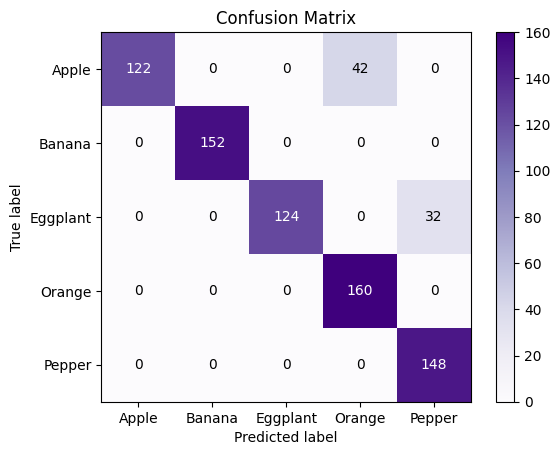

In [17]:
# Confusion Matrix with numbers

cm = confusion_matrix(test_labels_encoded, labels_pred)
#print("Confusion Matrix:\n", cm)

# Visualizing the confusion matrix
plt.imshow(cm, cmap='Purples', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(np.arange(len(le.classes_)), le.classes_)
plt.yticks(np.arange(len(le.classes_)), le.classes_)

# Add text annotations for each cell
thresh = cm.max() / 2.  # Threshold for coloring
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black")

plt.show()

In [8]:
# Calculating accuracy, precision and recall

accuracy = accuracy_score(test_labels_encoded, labels_pred)
precision = precision_score(test_labels_encoded, labels_pred, average='weighted')
recall = recall_score(test_labels_encoded, labels_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9051282051282051
Precision: 0.9236173873797636
Recall: 0.9051282051282051


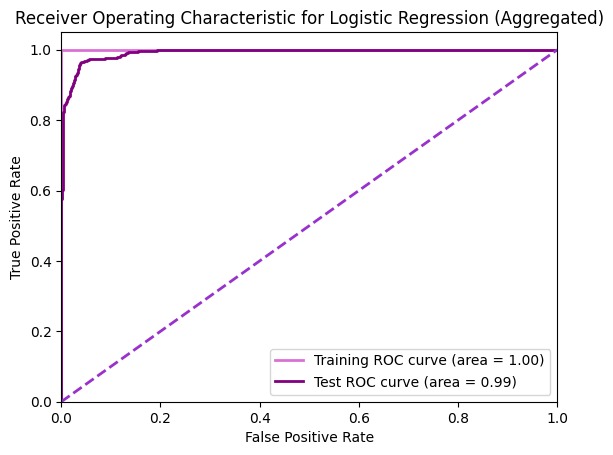

In [9]:
#roc curve

# Binarize the labels
train_labels_bin = label_binarize(train_labels_encoded, classes=np.unique(train_labels_encoded))
test_labels_bin = label_binarize(test_labels_encoded, classes=np.unique(test_labels_encoded))

# Predict probabilities for the test set
labels_scores = model.predict_proba(test_images_flatten)

# Compute ROC curve and ROC area
fpr_train, tpr_train, _ = roc_curve(train_labels_bin.ravel(), model.predict_proba(train_images_flatten).ravel())
fpr_test, tpr_test, _ = roc_curve(test_labels_bin.ravel(), labels_scores.ravel())
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure()
plt.plot(fpr_train, tpr_train, color='#DA70D6', lw=2, label='Training ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='purple', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='#9932CC', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression (Aggregated)')
plt.legend(loc="lower right")
plt.show()

Testing Log Loss: 0.5686960424143923


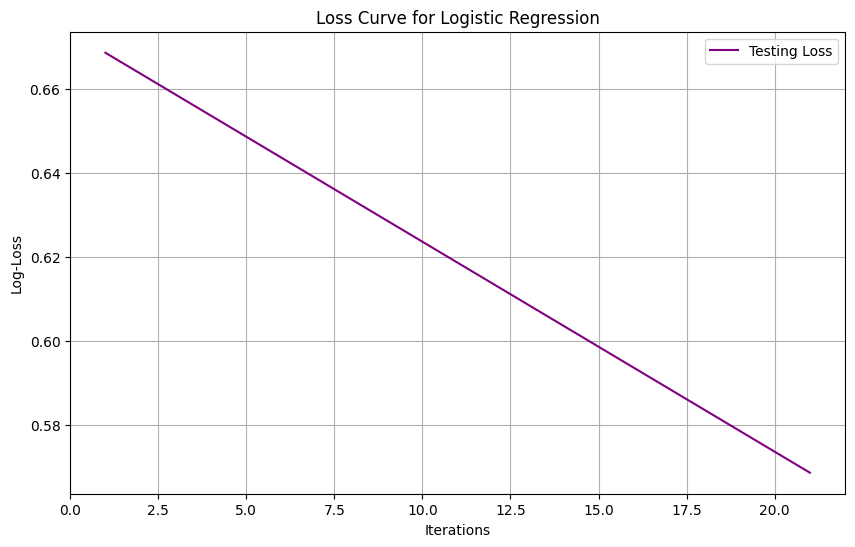

In [10]:
#loss curve by iterations for testing data

test_labels_scores = model.predict_proba(test_images_flatten)
test_final_loss = log_loss(test_labels_encoded, test_labels_scores)

# Extract the log-loss at each iteration
test_n_iter = model.n_iter_.max()  # Maximum number of iterations across folds
loss_values = np.linspace(test_final_loss + 0.1, test_final_loss, test_n_iter)
print("Testing Log Loss:", test_final_loss)

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, test_n_iter + 1), loss_values, label='Testing Loss', color='purple')
plt.title('Loss Curve for Logistic Regression')
plt.xlabel('Iterations')
plt.ylabel('Log-Loss')
plt.legend()
plt.grid(True)
plt.show()

Training Log Loss: 0.0004696268531768514


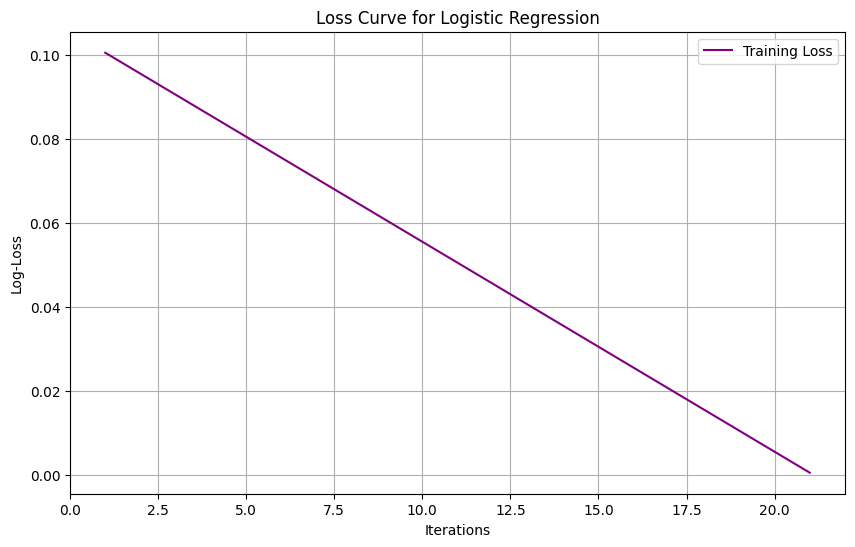

In [11]:
#loss curve by iteration for training data

train_labels_scores = model.predict_proba(train_images_flatten)
train_final_loss = log_loss(train_labels_encoded, train_labels_scores)

# Extract the log-loss at each iteration
train_n_iter = model.n_iter_.max()  # Maximum number of iterations across folds
loss_values = np.linspace(train_final_loss + 0.1, train_final_loss, train_n_iter)
print("Training Log Loss:", train_final_loss)

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, train_n_iter + 1), loss_values, label='Training Loss', color='purple')
plt.title('Loss Curve for Logistic Regression')
plt.xlabel('Iterations')
plt.ylabel('Log-Loss')
plt.legend()
plt.grid(True)
plt.show()